[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bachhvu/Amazon-NLP/blob/main/Model%20Development.ipynb)



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Preprocessed Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
import gensim
import itertools
from sklearn.utils import class_weight
import pickle

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Electronics_processed.csv', index_col=0)
df

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,review_text,review_time
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",5.0,1370131200,got ta gps got gps husband otr road trucker im...,2013-06-02
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]",1.0,1290643200,disappointed professional otr truck driver bou...,2010-11-25
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]",3.0,1283990400,impression well say unit truck four day prior ...,2010-09-09
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]",2.0,1290556800,great grafics poor gps going write long review...,2010-11-24
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",1.0,1317254400,major issue excuse support mine year got try r...,2011-09-29
...,...,...,...,...,...,...,...,...
1689183,A34BZM6S9L7QI4,B00LGQ6HL8,"Candy Cane ""Is it just me?""","[1, 1]",5.0,1405555200,boom pop pow deliver burned listening hour sin...,2014-07-17
1689184,A1G650TTTHEAL5,B00LGQ6HL8,"Charles Spanky ""Zumina Reviews""","[0, 0]",5.0,1405382400,thin light without compromising sound quality ...,2014-07-15
1689185,A25C2M3QF9G7OQ,B00LGQ6HL8,Comdet,"[0, 0]",5.0,1405555200,form factor durability better sound quality im...,2014-07-17
1689186,A1E1LEVQ9VQNK,B00LGQ6HL8,J. Chambers,"[0, 0]",5.0,1405641600,superb audio quality comfortable set earphone ...,2014-07-18


In [4]:
df = df.sample(n = 10000, random_state=42)

# Extra Data Wrangling

In [5]:
##########################################
## Classify ratings as good
##########################################

good_rate = len(df[df['overall'] >= 3])
bad_rate = len(df[df['overall'] < 3])

# Printing rates and their total numbers
print ('Good ratings : {} reviews for products'.format(good_rate))
print ('Bad ratings : {} reviews for products'.format(bad_rate))

Good ratings : 8900 reviews for products
Bad ratings : 1100 reviews for products


In [6]:
df['rating_class'] = df['overall'].apply(lambda x: 0 if x < 3 else 1)
df.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,review_text,review_time,rating_class
1360852,AVCMFK6FBAXO3,B0083C8B30,"Edward Jasudowich ""Edsgolfin""","[1, 1]",5.0,1358985600,switch pioneer simplifed life improved home th...,2013-01-24,1
1672835,A3M64BWMQO6JAL,B00GTGETFG,Amazon Customer,"[0, 0]",5.0,1400630400,power demand lot power needed use charge three...,2014-05-21,1
1626762,A1S9FUIB8R4ZO7,B00DTPYRKC,L T.,"[0, 0]",5.0,1387843200,replacement hdd macbook pro bought ssd replace...,2013-12-24,1
62247,A1V7MCPGTUJ6YY,B00009EHJV,"Bud ""Mac user""","[0, 0]",5.0,1303430400,work great mac vmware fusion installed mac usi...,2011-04-22,1
568677,A3Q2XTSWJBGB89,B0027JRX52,Marcos,"[0, 0]",4.0,1347667200,good solution carry necessary gear occasion wa...,2012-09-15,1


In [7]:
df['review_time'] = pd.to_datetime(df['review_time'], format='%Y/%m/%d')

# Exploratory Data Analysis

Summary Statistics

In [ ]:
# Statistics of non-numeric variables

# Number of unique customers
print('\nNumber of unique customers : {}'.format(len(df['reviewerID'].unique())))
      
# Number of unique products
print('\nNumber of unique products : {}'.format(len(df['asin'].unique())))
      
# Review number per unique customer
print('\nReview per customer: {}'.format((len(df)/len(df['reviewerID'].unique()))))      

# Review number per unique product 
print('\nReview per product: {}'.format((len(df)/len(df['asin'].unique()))))


Number of unique customers : 192403

Number of unique products : 63001

Review per customer: 8.779416121370248

Review per product: 26.81205060237139


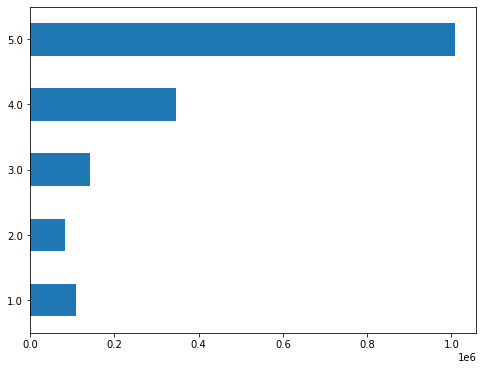

In [ ]:
plt.figure(figsize=(8,6))
df['overall'].value_counts().sort_index().plot(kind="barh")

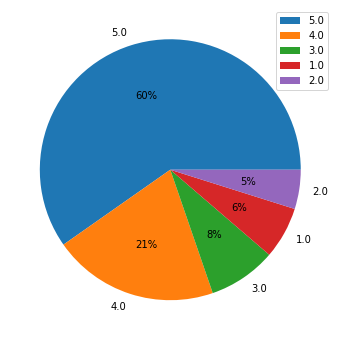

In [ ]:
plt.figure(figsize=(8,6))
plt.pie(df['overall'].value_counts(), labels = df['overall'].value_counts().index, autopct='%1.0f%%')
plt.legend()

Plot number of review per day

In [ ]:
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
import matplotlib.ticker as ticker
from datetime import datetime, timedelta

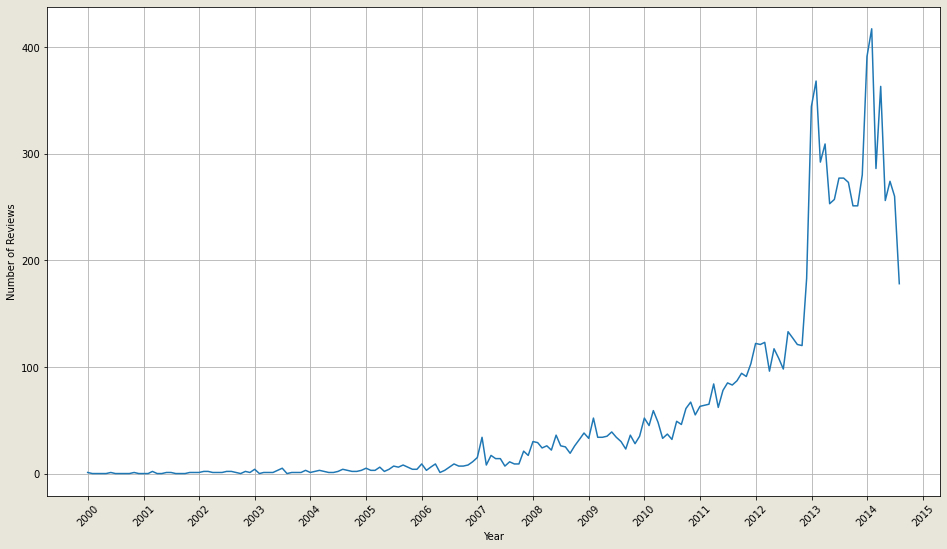

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
fig.patch.set_facecolor('#E8E5DA')

ax.plot(df.groupby(pd.Grouper(key='review_time', freq='M')).count().sort_index().index, df.groupby(pd.Grouper(key='review_time', freq='M')).count()['review_text'])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Number of Reviews", fontsize=10)
ax.grid()

Plot number of unique customer leaving review per month

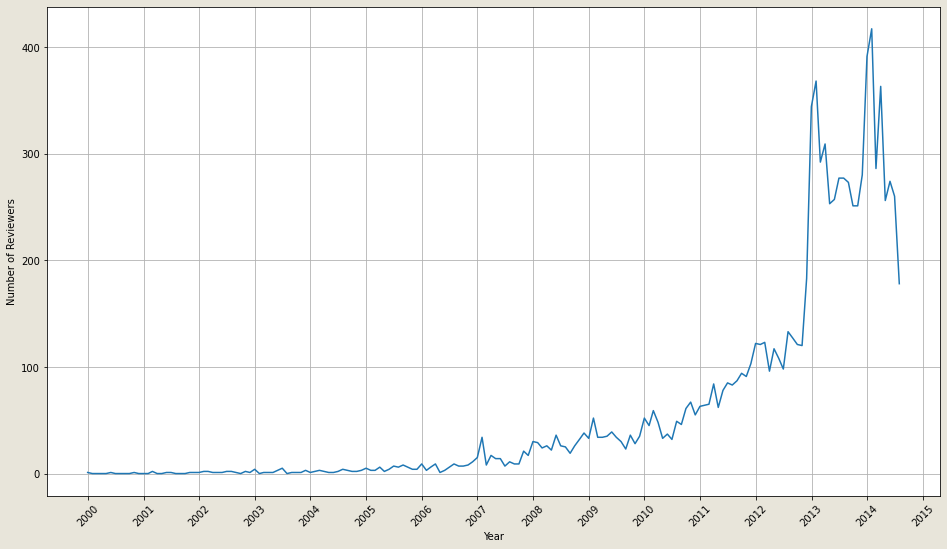

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
fig.patch.set_facecolor('#E8E5DA')

ax.plot(df.groupby(pd.Grouper(key='review_time', freq='M')).count().sort_index().index, df.groupby(pd.Grouper(key='review_time', freq='M')).count()['reviewerID'])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Number of Reviewers", fontsize=10)
ax.grid()

Plot number of product reviewed per month

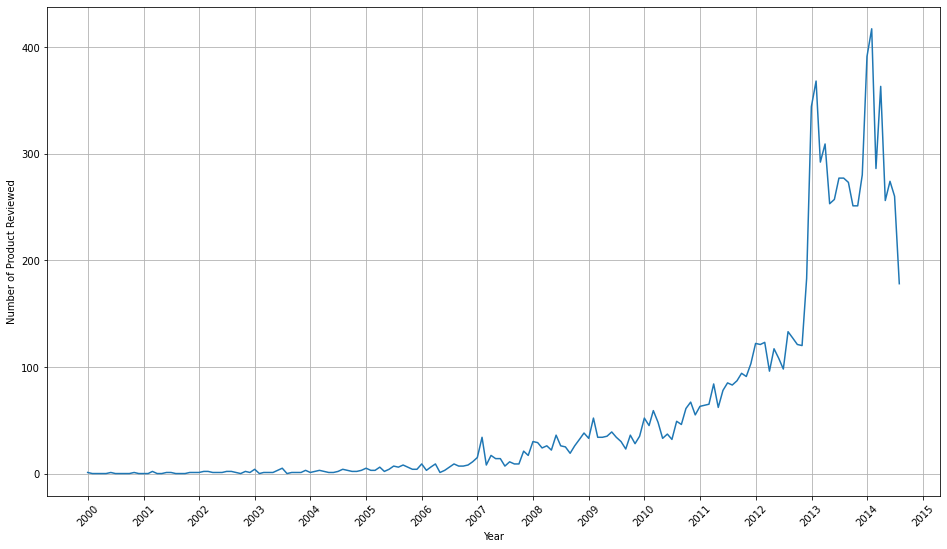

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(df.groupby(pd.Grouper(key='review_time', freq='M')).count().sort_index().index, df.groupby(pd.Grouper(key='review_time', freq='M')).count()['asin'])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Number of Product Reviewed", fontsize=10)
ax.grid()


In [ ]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(18, 6))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

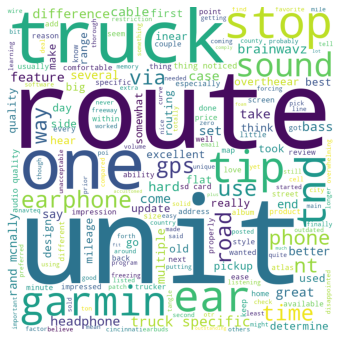

In [ ]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width= 800, height = 800, random_state=1, background_color='white', stopwords = STOPWORDS).generate(str(df['review_text'].values))
# Plot
plot_cloud(wordcloud)

# Model Development

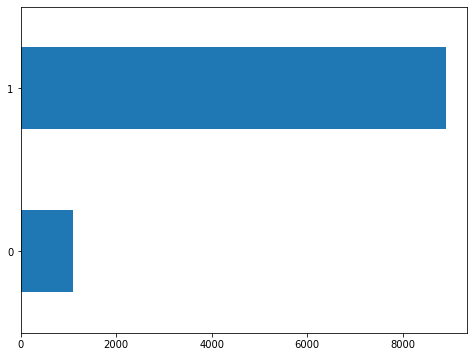

In [ ]:
plt.figure(figsize=(8,6))
df['rating_class'].value_counts().sort_index().plot(kind="barh")

In [8]:
df = df.dropna(subset=['review_text'])

In [9]:
df['review_text'].isnull().values.any()

False

In [10]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.7, use_idf=True)
# fit the vectorizer using the text data
tfid = tfid_vectorizer.fit(df['review_text'])
# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

tfid_matrix = tfid_vectorizer.transform(df['review_text']).todense()
feature_names = tfid_vectorizer.get_feature_names()

# store the tf-idf array into pandas dataframe
df2 = pd.DataFrame(tfid_matrix, columns=feature_names)
df2['rating_class'] = df['rating_class'].to_numpy()
df2

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aa aaa,aa battery,aaa,aaa battery,aac,ab,aberration,ability,ability play,ability use,able,able access,able add,able adjust,able charge,able connect,able control,able easily,able figure,able find,able fit,able fully,able get,able hear,able hook,able keep,able listen,able mount,able move,able pick,able play,able plug,able pull,able put,able reach,able remove,able see,able set,able shoot,...,yet try,yet use,yield,yongnuo,young,younger,youre,youtube,youtube video,yr,yr old,zagg,zalman,zeikos,zeiss,zen,zen vision,zero,zero issue,zip,zip tie,zipped,zipper,zippered,zippered pocket,zone,zoom,zoom camera,zoom digital,zoom feature,zoom lens,zoom picture,zoom range,zoom ring,zoom setting,zoom would,zoomed,zooming,zune,rating_class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [13]:
pickle.dump(tfid_vectorizer.vocabulary_,open("/content/drive/MyDrive/feature.pkl","wb"))

Split the data into train and test subset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df2[feature_names], df2['rating_class'], test_size=0.25, random_state=42)

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, make_scorer
aucpr_score = make_scorer(average_precision_score, pos_label=1)

## Support Vector Machine

In [ ]:
classifier = LinearSVC(class_weight='balanced', random_state=0)

In [ ]:
alpha_list = np.linspace(0.01,0.1,10)
alpha_list = np.around(alpha_list, decimals=4)
kf = StratifiedKFold(n_splits=5, shuffle=False)
params = {'C': alpha_list}

In [ ]:
import time
start_time = time.time()
grid_no_up = GridSearchCV(classifier, param_grid=params, cv=kf, n_jobs=-1, verbose=1, scoring=aucpr_score).fit(x_train, y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Done training in 53.52440619468689 seconds.


{'C': 0.05}
0.9566150538095524
0.004291498202758156


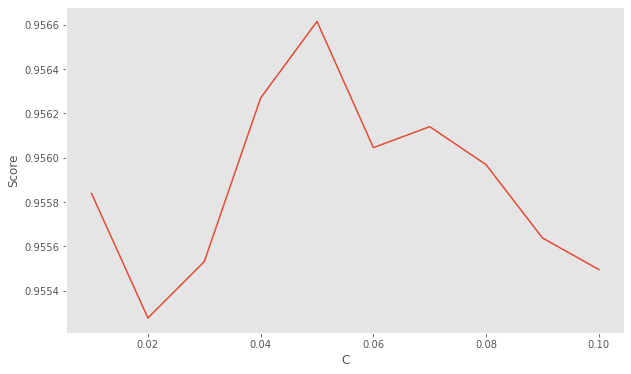

In [ ]:
results = pd.DataFrame()
# collect parameter list
results['alpha'] = grid_no_up.cv_results_['param_C'].data
# collect test scores
results['score'] = grid_no_up.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(results['alpha'], results['score'])
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

print(grid_no_up.best_params_)
print(grid_no_up.best_score_)
print(grid_no_up.cv_results_['std_test_score'][grid_no_up.best_index_])

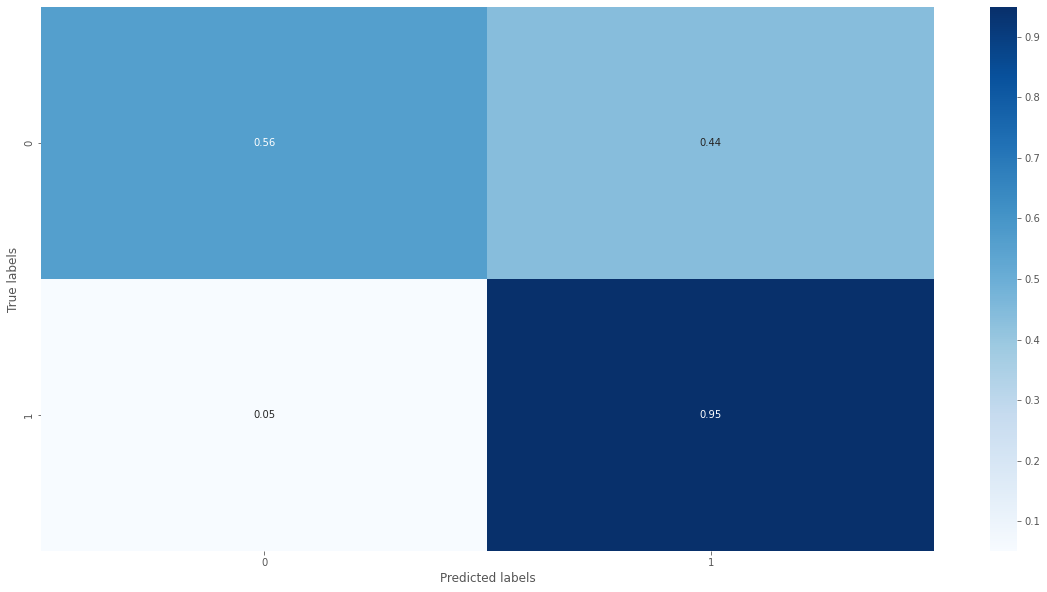

In [ ]:
base_preds = classifier.fit(x_train, y_train).predict(x_test)
labels = df['rating_class'].unique()
cm = confusion_matrix(y_test, base_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [ ]:
#Quick diagnostics
print(classification_report(y_val.astype(str), base_preds.astype(str)))

              precision    recall  f1-score   support

           0       0.58      0.56      0.57       281
           1       0.94      0.95      0.95      2219

    accuracy                           0.91      2500
   macro avg       0.76      0.76      0.76      2500
weighted avg       0.90      0.91      0.90      2500



## Logistic Regression

In [ ]:
classifier = LogisticRegression(random_state=0, class_weight='balanced')

In [ ]:
alpha_list = np.linspace(0.1,1,10)
alpha_list = np.around(alpha_list, decimals=4)
kf = StratifiedKFold(n_splits=5, shuffle=False)
params = {'C': alpha_list}

In [ ]:
import time
start_time = time.time()
grid_no_up = GridSearchCV(classifier, param_grid=params, cv=kf, n_jobs=-1, verbose=1, scoring=aucpr_score).fit(x_train, y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Done training in 629.3141806125641 seconds.


{'C': 1.0}
0.9559103188314253
0.004602760267700717


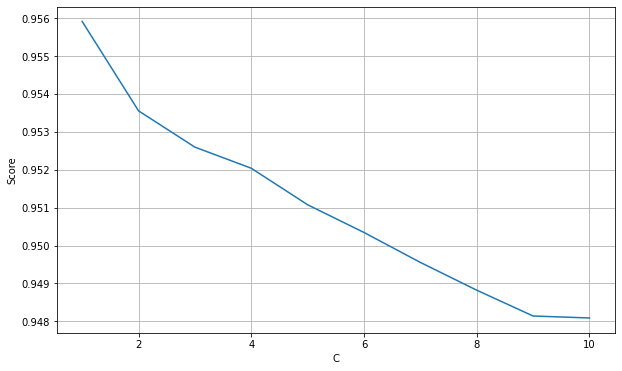

In [ ]:
results = pd.DataFrame()
# collect parameter list
results['alpha'] = grid_no_up.cv_results_['param_C'].data
# collect test scores
results['score'] = grid_no_up.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(results['alpha'], results['score'])
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

print(grid_no_up.best_params_)
print(grid_no_up.best_score_)
print(grid_no_up.cv_results_['std_test_score'][grid_no_up.best_index_])

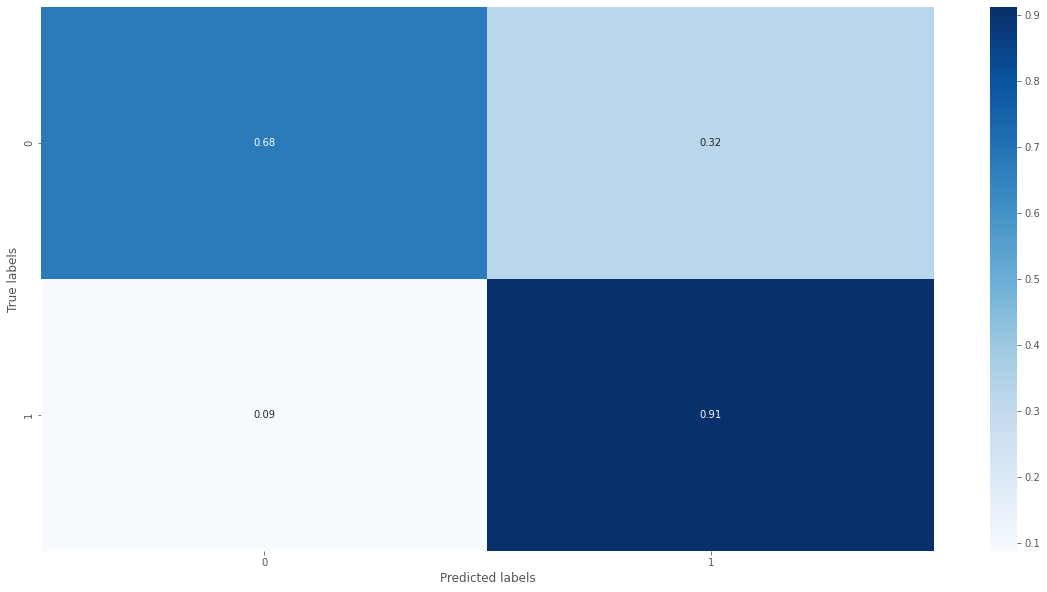

In [ ]:
LRClassifier = classifier.fit(x_train, y_train)
base_preds = LRClassifier.predict(x_test)
labels = df['rating_class'].unique()
cm = confusion_matrix(y_test, base_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [ ]:
#Quick diagnostics
print(classification_report(y_test.astype(str), base_preds.astype(str)))

              precision    recall  f1-score   support

           0       0.49      0.68      0.57       281
           1       0.96      0.91      0.93      2219

    accuracy                           0.88      2500
   macro avg       0.72      0.79      0.75      2500
weighted avg       0.90      0.88      0.89      2500



## Deep Learning

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)
documents = [_text.split() for _text in df_train.review_text]

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, window=7, min_count=32, workers=8)

In [ ]:
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1915


In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=32)

(10831972, 14318176)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.review_text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 26233


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.review_text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.review_text), maxlen=300)

In [ ]:
y_train = df_train.rating_class.tolist()
y_test = df_test.rating_class.tolist()

y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [ ]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(26233, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          7869900   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 8,089,677
Trainable params: 219,777
Non-trainable params: 7,869,900
_________________________________________________________________


In [ ]:
pr_metric = AUC(curve='PR', num_thresholds=1000) # The higher the threshold value, the more accurate it is calculated.

In [ ]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=[pr_metric])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = np.ravel(y_train))

class_weights = {i : class_weights[i] for i in range(2)}
class_weights

{0: 4.5787545787545785, 1: 0.5612932195779075}

In [ ]:
H = model.fit(x_train, y_train, batch_size=1024, epochs=20, class_weight=class_weights, validation_split=0.05, verbose=1, callbacks=callbacks)

Epoch 1/20
7/7 [==============================] - 17s 2s/step - loss: 0.6659 - auc: 0.9273 - val_loss: 0.6639 - val_auc: 0.9325 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - 12s 2s/step - loss: 0.5990 - auc: 0.9566 - val_loss: 0.6267 - val_auc: 0.9435 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - 12s 2s/step - loss: 0.5506 - auc: 0.9653 - val_loss: 0.5321 - val_auc: 0.9558 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - 12s 2s/step - loss: 0.5094 - auc: 0.9733 - val_loss: 0.6606 - val_auc: 0.9651 - lr: 0.0010
Epoch 5/20
7/7 [==============================] - 11s 2s/step - loss: 0.5030 - auc: 0.9749 - val_loss: 0.4609 - val_auc: 0.9670 - lr: 0.0010
Epoch 6/20
7/7 [==============================] - 12s 2s/step - loss: 0.4917 - auc: 0.9761 - val_loss: 0.4927 - val_auc: 0.9682 - lr: 0.0010
Epoch 7/20
7/7 [==============================] - 12s 2s/step - loss: 0.4730 - auc: 0.9781 - val_loss: 0.4983 - val_auc: 0.9718 - lr: 0.0010
Epoch 8/20
7/

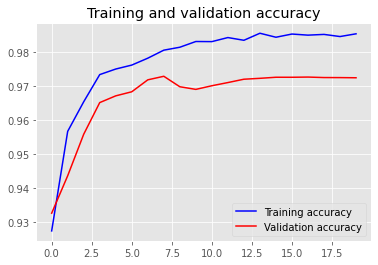

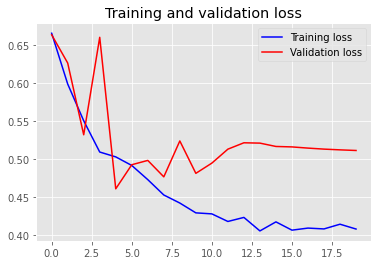

In [ ]:
acc = H.history['auc']
val_acc = H.history['val_auc']
loss = H.history['loss']
val_loss = H.history['val_loss']
 
epochs = range(len(acc))

plt.style.use("ggplot")
 
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=5000)
print()
print("Accuracy:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 1s 616ms/step - loss: 0.4972 - auc: 0.9779

Accuracy: 0.9778517484664917
LOSS: 0.4971940517425537
CPU times: user 454 ms, sys: 173 ms, total: 627 ms
Wall time: 687 ms


In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    return " ".join(tokens)

def decode_sentiment(score, include_neutral):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= 0.4:
            label = 'NEGATIVE'
        elif score >= 0.7:
            label = 'POSITIVE'
        return label
    else:
        return 0 if score < 0.5 else 1 

def predict(model, tokenizer, text, include_neutral=False, sequence_length=300):
    
    start_at = time.time()
    # Tokenize text
    text = [preprocess(t) for t in text]
    X = pad_sequences(tokenizer.texts_to_sequences(text), maxlen=sequence_length)
    # Predict
    score = model.predict(X, batch_size=50)
    # Decode sentiment
    labels = []
    for s in score:
        label = decode_sentiment(s, include_neutral=include_neutral)
        labels.append(label)

    return {"label": labels, "score": score,
       "elapsed_time": time.time()-start_at}

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.rating_class)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 1s 753ms/step
CPU times: user 682 ms, sys: 164 ms, total: 846 ms
Wall time: 956 ms


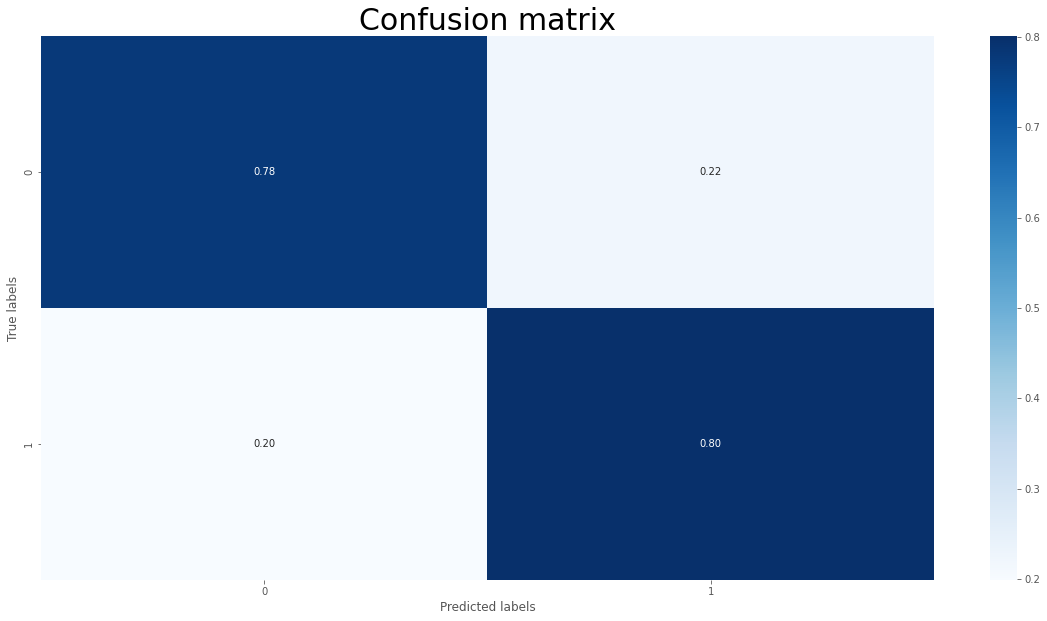

In [ ]:
cm = confusion_matrix(y_test_1d, y_pred_1d)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
plt.title("Confusion matrix", fontsize=30)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.33      0.78      0.46       281
           1       0.97      0.80      0.88      2219

    accuracy                           0.80      2500
   macro avg       0.65      0.79      0.67      2500
weighted avg       0.89      0.80      0.83      2500



# Save model

In [ ]:
pickle.dump(model, open('/content/drive/MyDrive/model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://ce57f8f8-ffef-41b0-8960-6a032d14db7d/assets


In [ ]:
with open('/content/drive/MyDrive/classifier.pkl', 'wb') as file:  
    pickle.dump(LRClassifier, file)

In [ ]:
!zip -r model.zip {/content/drive/MyDrive}

	zip warning: name not matched: {/content/drive/MyDrive}

zip error: Nothing to do! (try: zip -r model.zip . -i {/content/drive/MyDrive})


drive  sample_data
